In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.data import *

In [29]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

#This is a list of numbers from 0 to the end (t=0 to t=1460 in this case, because there are 3 years and 1 t = 1 day)
#Can consider this to be the set of values for the x axis
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series. The Series is the actual graph
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

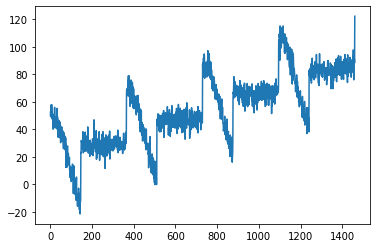

In [8]:
plt.plot(series)

In [32]:
time[0]

0.0

In [10]:
split_time = 1000

#This means the training set will be from t=0 to t=999
time_train = time[:split_time]
#This is where you get the actual graph for training set
x_train = series[:split_time]


time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  #Get the Dataset
  ds = Dataset.from_tensor_slices(series)
  #Get windows of size (window_size + 1)
  ds = ds.window(window_size+1, shift=1,drop_remainder=True)
  #Batch the windows using the same window size
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  #Shuffle and split into x and y values
  ds = ds.shuffle(shuffle_buffer_size).map(lambda data: (data[:-1], data[-1:]))
  #Batch the windows to use for training batches
  ds = ds.batch(batch_size).prefetch(1)

  return ds


In [15]:
#This dataset will be the set of x,y values from the x_train series
#This dataset contains multiple values
#Each window will initially have 21 values
#The Xs will be the first 20 values and the Ys will be the last value
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float32, tf.float32)>


In [37]:
#Define using l0 so you can easily get the weights of this layer
#Input shape is 20 (This is the size of the Xs). It's not 21 because you sliced the last element to be the corresponding Y value
l0 = tf.keras.layers.Dense(1,input_shape=[window_size])

model = tf.keras.models.Sequential([l0])
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=200,verbose=0)

In [25]:
#This will have 21 elements: 20 weights and 1 bias
#This is essentially linear regression
l0.get_weights()

[array([[-0.05046791],
        [ 0.00706722],
        [ 0.04420922],
        [-0.02246715],
        [ 0.03018962],
        [ 0.00119399],
        [-0.00785628],
        [ 0.02261792],
        [-0.03813328],
        [ 0.03697893],
        [-0.00792323],
        [ 0.01430174],
        [-0.05023559],
        [ 0.03198667],
        [ 0.02461769],
        [ 0.07757877],
        [ 0.01874089],
        [ 0.14518392],
        [ 0.28232434],
        [ 0.45900348]], dtype=float32), array([0.03208051], dtype=float32)]

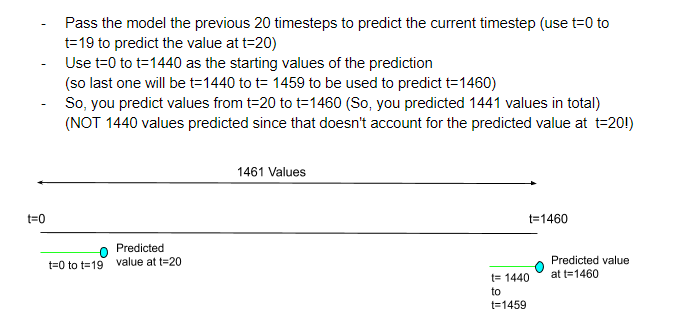

In [70]:
preds = []

#i will be from i=0 to i=1440
for i in range(len(series)- window_size):
  #Must expand_dims to change shape from (20) to (1,20)
  pred_series = np.expand_dims(series[i:i+20],axis=0)
  pred = model.predict(pred_series)
  #Append all predictions to the pred list. This will be predicted values of t=20 to t=1460
  preds.append(pred)

In [76]:
for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 20), dtype=float32, numpy=
array([[ 44.37749   ,  51.99936   ,  43.93912   ,  35.775608  ,
         40.913044  ,  36.58728   ,  44.171944  ,  46.010376  ,
         54.289753  ,  47.53197   ,  44.792107  ,  50.02539   ,
         34.813927  ,  47.039402  ,  49.707848  ,  38.453266  ,
         51.55811   ,  47.52543   ,  43.75058   ,  48.98545   ],
       [ 31.51689   ,  28.383394  ,  29.097626  ,  34.92262   ,
         25.599964  ,  31.317053  ,  27.594559  ,  27.541286  ,
         34.147957  ,  32.805748  ,  32.771015  ,  35.255863  ,
         28.8587    ,  32.188858  ,  27.253374  ,  30.451357  ,
         28.205822  ,  29.367723  ,  31.884932  ,  24.84464   ],
       [ -6.752203  , -10.269627  , -16.000174  ,  -8.391326  ,
        -14.525441  ,  -7.3181014 , -14.747516  ,  -2.8571053 ,
        -14.97132   , -13.105373  ,  -7.8591013 , -18.504087  ,
        -11.626857  ,  -6.6340213 , -21.603775  , -13.030719  ,
        -13.032789  , -10.792066  ,  23.163013  ,  

In [77]:
#Only get the predicted values of the validation set 
#preds[0] is the predicted value of t=20, using the first 20 values (t=0 to t=19)
#Index the preds[800:]this will be the predicted values of t=1000 all the way to t=1460
preds_valid = preds[split_time-window_size:]

In [82]:
q = np.array(preds_valid)

In [52]:
#To index the predicted values, to get a 1D matrix
#preds_valid is a 3d array. You index all the elements in the first dimension, and index the first element of the second and third dimension
'''

[ 
  [[t=0]]
  [[t=1]]
  [[t=2]]
]

'''
results = np.array(preds_valid)[:, 0, 0]
print(results)

[ 63.271683  67.0892    67.89287   65.872345  62.465897  64.55221
  64.259224  66.50266   66.1066    66.179016  63.584423  67.60928
  65.25088   69.70671   64.70623   68.9613    64.53405   64.62222
  61.39011   62.712543  62.04982   65.266365  62.09053   63.516716
  67.286865  70.86731   68.315796  65.34863   64.62551   65.72014
  63.4672    61.634365  57.980415  61.984554  63.62583   63.558266
  66.231346  62.662537  59.8242    62.123154  65.18117   69.31872
  65.624626  66.15105   64.7094    64.8011    66.67583   66.07047
  61.18165   65.931694  68.06962   66.65171   64.19896   66.240074
  64.96312   63.767544  62.579876  63.047123  66.562225  66.50232
  64.71669   65.8148    58.243187  64.29251   60.4946    61.063904
  58.95788   60.640923  62.590755  64.50365   64.23517   64.949265
  64.693275  66.027695  62.153423  65.98606   63.84922   60.262188
  61.99673   65.18211   68.41753   66.166306  63.71458   63.89066
  68.88892   69.890915  67.76991   67.78941   67.590675  66.142975
  6

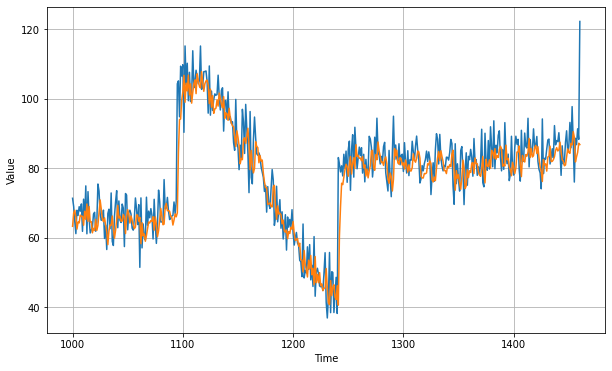

In [63]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [50]:
tmp.shape

(461, 1, 1)

In [68]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0799537

In [71]:
len(preds)

1441